In [23]:
import math

import contextily as cx
import folium
import geopandas as gpd
import jenkspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xyzservices.providers as xyz
import yaml
from matplotlib.colors import to_hex
from shapely import Point, Polygon
from sklearn.preprocessing import minmax_scale

with open("../data/crs.yaml", "r") as fp:
    crs = yaml.safe_load(fp)
with open("../plotting_config.yaml", "r") as fp:
    config = yaml.safe_load(fp)

In [ ]:
def determine_square_boundary(
    boundary_polygon: Polygon,
) -> tuple[float, float, float, float]:
    """
    Takes a city boundary as a polygon and calculates its bounds as a square.
    """
    minx, miny, maxx, maxy = boundary_polygon.bounds
    diff_y = maxy - miny
    diff_x = maxx - minx
    offset = abs(diff_y - diff_x) / 2
    if diff_y >= diff_x:
        minx -= offset
        maxx += offset
    else:
        miny -= offset
        maxy += offset
    return minx, miny, maxx, maxy


def get_boundary_centroid(boundary: gpd.GeoDataFrame) -> tuple[float, float]:
    """
    return longitude, latitude of the centroid in EPSG:4326 (WGS84)
    """
    lat, lon = boundary.centroid.to_crs(4326)[0].xy
    return lon[0], lat[0]


def determine_ellipticity_bins(df: pd.DataFrame, n_classes: int = 6) -> list[float]:
    return jenkspy.jenks_breaks(
        df.query("ellipticity.notna()")["ellipticity"], n_classes=n_classes
    )

In [ ]:
CITY = "helsinki"
VERSION = ""
CMAP = "RdYlBu_r"

In [ ]:
data = pd.read_csv(f"../output/{CITY}/{VERSION}/merged.csv")
data["geometry"] = data.apply(lambda x: Point(x["stop_lon"], x["stop_lat"]), axis=1)
data = gpd.GeoDataFrame(data, geometry="geometry", crs=4326)

In [ ]:
boundary = gpd.read_file(f"../data/osm/{CITY}/boundary_land.geojson").to_crs(crs[CITY])
boundary_polygon = boundary.geometry[0]

In [28]:
to_plot_el = data.sort_values("ellipticity", ascending=True).to_crs(crs[CITY])

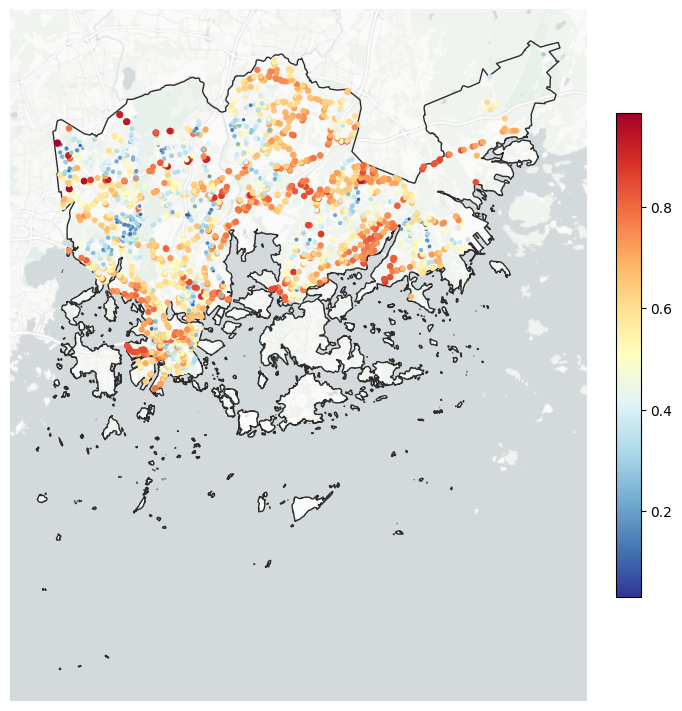

In [29]:
fig, ax = plt.subplots(figsize=(7, 7), layout="constrained")
boundary.plot(ax=ax, fc="none", ec="#2d2d2d")
gpd.clip(to_plot_el, boundary_polygon).plot(
    column="ellipticity",
    legend=True,
    legend_kwds={"shrink": 0.7},
    markersize=minmax_scale(
        gpd.clip(to_plot_el, boundary_polygon)["ellipticity"], feature_range=(1, 16)
    ),
    cmap=CMAP,
    ax=ax,
)
cx.add_basemap(
    ax,
    crs=crs[CITY],
    source=cx.providers.CartoDB.PositronNoLabels,
    alpha=1,
    attribution=False,
)
ax.axis("off")
ax.margins(0)
for i in ["png"]:
    fig.savefig(
        f"../output/{CITY}/ellipticity.{i}",
        dpi=300,
        facecolor="white",
        bbox_inches="tight",
        # pad_inches=0.1,
        metadata=config["metadata"][i],
    )

In [ ]:
bins = determine_ellipticity_bins(to_plot_el)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
minx, miny, maxx, maxy = determine_square_boundary(boundary_polygon)
ax.set_xlim([math.floor(minx), math.ceil(maxx)])
ax.set_ylim([math.floor(miny), math.ceil(maxy)])
boundary.plot(ax=ax, fc="none", ec="#2d2d2d")
gpd.clip(to_plot_el, boundary_polygon).query("ellipticity.notna()").plot(
    column="ellipticity",
    legend=True,
    cmap=CMAP,
    ax=ax,
    scheme="UserDefined",
    classification_kwds=dict(
        bins=bins[1:],
    ),
    markersize=minmax_scale(
        gpd.clip(to_plot_el, boundary_polygon).query("ellipticity.notna()")[
            "ellipticity"
        ],
        feature_range=(2, 16),
    ),
)
ax.margins(0.1)
ax.axis("off")
cx.add_basemap(
    ax,
    crs=crs[CITY],
    source=cx.providers.CartoDB.PositronNoLabels,
    alpha=1,
    attribution=False,
)
for i in ["png"]:
    fig.savefig(
        f"../output/{CITY}/ellipticity_jenks.{i}",
        dpi=300,
        facecolor="white",
        pad_inches=0,
        metadata=config["metadata"][i],
    )

In [32]:
to_plot_el_f = (
    to_plot_el.query("ellipticity.notna()")
    .drop_duplicates(subset=["stop_id"])
    .reset_index(drop=True)[
        [
            "stop_id",
            "stop_name",
            "ellipticity",
            "geometry",
            "cluster",
            "number_of_accessible_stops",
        ]
    ]
    .copy()
)
to_plot_el_f["geometry"] = to_plot_el_f["geometry"].buffer(75)

In [33]:
lon, lat = get_boundary_centroid(boundary)
m = folium.Map(location=[lon, lat], zoom_start=12, tiles=xyz.CartoDB.Voyager)

cp = folium.Choropleth(
    geo_data=to_plot_el_f.drop_duplicates(subset=["cluster"]),
    name="ellipticity",
    data=to_plot_el_f.drop_duplicates(subset=["cluster"]),
    columns=["stop_id", "ellipticity"],
    key_on="feature.properties.stop_id",
    fill_color="RdYlBu_r",
    line_opacity=0.2,
    fill=True,
    fill_opacity=0.85,
    legend_name="ellipticity",
    bins=bins,
    nan_fill_color="black",
).add_to(m)

folium.GeoJsonTooltip(
    [
        "stop_id",
        "stop_name",
        "ellipticity",
        "number_of_accessible_stops",
        "cluster",
    ],
)  # .add_to(cp.geojson)

popup = folium.GeoJsonPopup(
    fields=[
        "stop_id",
        "stop_name",
        "ellipticity",
        "number_of_accessible_stops",
        "cluster",
    ],
    # aliases=["State", "% Change"],
    # localize=True,
    labels=True,
    # style="background-color: yellow;",
    sticky=True,
    popup_options={"sticky": True},
)
popup.add_to(cp.geojson)

# folium.Choropleth(
#     geo_data=to_plot_ec_f,
#     name="eccentricity",
#     data=to_plot_ec_f,
#     columns=["stop_id", "eccentricity"],
#     key_on="feature.properties.stop_id",
#     fill_color="RdYlBu_r",
#     line_opacity=0.2,
#     fill=True,
#     fill_opacity=0.85,
#     legend_name="eccentricity",
#     bins=bins_ec,
#     nan_fill_color="black",
# ).add_to(m)


folium.LayerControl().add_to(m)
m

In [34]:
m.save(f"../output/{CITY}/ellipticity_folium.html")

In [35]:
to_plot_el_f.query("stop_name == 'Prado - Atocha'")
to_plot_el_f.query("stop_name == 'Estación del Arte'")

Empty GeoDataFrame
Columns: [stop_id, stop_name, ellipticity, geometry, cluster, number_of_accessible_stops]
Index: []

In [36]:
palette = sns.color_palette("RdYlBu_r", len(bins))

In [37]:
def colorize(
    x: float, bins: list[np.float64], palette: list[tuple[float, float, float]]
) -> str:
    result = 0
    for i, v in enumerate(bins):
        if x < v:
            result = i
            break

    return to_hex(palette[result])

In [38]:
colorize(0.9, bins, palette)

'#dd3d2d'

In [39]:
m = folium.Map(location=[lon, lat], zoom_start=12, tiles=xyz.CartoDB.Voyager)
fg = folium.FeatureGroup(name="stops")
for row in data.drop_duplicates(subset=["cluster"]).itertuples():
    p = folium.Popup(
        f"stop_name: {row.stop_name}\nstop_id: {row.stop_id}\ncluster: {row.cluster}\nellipticity: {row.ellipticity}",
        parse_html=True,
        # max_width="100%",
        sticky=True,
    )
    fg.add_child(
        folium.CircleMarker(
            location=[row.stop_lat, row.stop_lon],
            radius=10,
            # popup=f"{row.cluster}",
            popup=p,
            fill_color=colorize(row.ellipticity, bins, palette),
            fill=True,
            color="none",
            fill_opacity=0.85,
        ),
    )
m.add_child(fg)
m